##  1. import Libaray

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

## 2. Load data

In [21]:
data=pd.read_csv("NSE.csv")

In [22]:
data.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


In [6]:
data.tail()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
1230,2013-10-14,160.85,161.45,157.70,159.3,159.45,1281419.0,2039.09
1231,2013-10-11,161.15,163.45,159.00,159.8,160.05,1880046.0,3030.76
1232,2013-10-10,156.00,160.80,155.85,160.3,160.15,3124853.0,4978.80
1233,2013-10-09,155.70,158.20,154.15,155.3,155.55,2049580.0,3204.49
1234,2013-10-08,157.00,157.80,155.20,155.8,155.80,1720413.0,2688.94


In [24]:
# sort with date 
data['Date']=pd.to_datetime(data['Date'])
print(type(data.Date[0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [25]:
df=data.sort_values(by='Date')
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
1234,2013-10-08,157.00,157.80,155.20,155.8,155.80,1720413.0,2688.94
1233,2013-10-09,155.70,158.20,154.15,155.3,155.55,2049580.0,3204.49
1232,2013-10-10,156.00,160.80,155.85,160.3,160.15,3124853.0,4978.80
1231,2013-10-11,161.15,163.45,159.00,159.8,160.05,1880046.0,3030.76
1230,2013-10-14,160.85,161.45,157.70,159.3,159.45,1281419.0,2039.09


In [26]:
df.reset_index(inplace=True)

In [29]:
df.head()

,index,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,1234,2013-10-08,157.00,157.80,155.20,155.8,155.80,1720413.0,2688.94
1,1233,2013-10-09,155.70,158.20,154.15,155.3,155.55,2049580.0,3204.49
2,1232,2013-10-10,156.00,160.80,155.85,160.3,160.15,3124853.0,4978.80
3,1231,2013-10-11,161.15,163.45,159.00,159.8,160.05,1880046.0,3030.76
4,1230,2013-10-14,160.85,161.45,157.70,159.3,159.45,1281419.0,2039.09


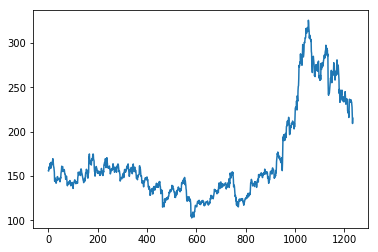

In [30]:
plt.plot(df['Close'])

In [34]:
df1=df['Close']

## 3. prepare data 

In [36]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler 
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
df1

array([[0.23823398],
       [0.2371134 ],
       [0.25773196],
       ...,
       [0.51792918],
       [0.47758853],
       [0.50425818]])

In [39]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.70)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [40]:
training_size,test_size

(864, 371)

In [44]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [45]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [46]:
print(X_train.shape), print(y_train.shape)

(763, 100)
(763,)


(None, None)

In [47]:
print(X_test.shape), print(ytest.shape)

(270, 100)
(270,)


(None, None)

In [48]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

## 4.model building

In [49]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [51]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [54]:
model.fit(X_train,y_train,validation_split=0.1,epochs=60,batch_size=64,verbose=1)

Train on 686 samples, validate on 77 samples
Epoch 1/60
686/686 [==============================] - 4s 6ms/sample - loss: 2.2819e-04 - val_loss: 1.3670e-04
Epoch 2/60
686/686 [==============================] - 4s 6ms/sample - loss: 2.2352e-04 - val_loss: 1.4367e-04
Epoch 3/60
686/686 [==============================] - 5s 7ms/sample - loss: 2.1545e-04 - val_loss: 1.3348e-04
Epoch 4/60
686/686 [==============================] - 4s 6ms/sample - loss: 2.1313e-04 - val_loss: 1.9827e-04
Epoch 5/60
686/686 [==============================] - 4s 6ms/sample - loss: 2.1841e-04 - val_loss: 1.2992e-04
Epoch 6/60
686/686 [==============================] - 4s 6ms/sample - loss: 2.0643e-04 - val_loss: 1.4275e-04
Epoch 7/60
686/686 [==============================] - 4s 6ms/sample - loss: 1.9939e-04 - val_loss: 1.2444e-04
Epoch 8/60
686/686 [==============================] - 4s 6ms/sample - loss: 1.9945e-04 - val_loss: 1.3315e-04
Epoch 9/60
686/686 [==============================] - 4s 6ms/sample - loss:

In [67]:
### Lets Do the prediction and check performance metrics
test_predict=model.predict(X_test)

In [71]:
##Transformback to original form
test_predict1=scaler.inverse_transform(test_predict)

In [72]:
test_predict1

array([[0.38643333],
       [0.4161328 ],
       [0.46171895],
       [0.43914735],
       [0.4499515 ],
       [0.4609513 ],
       [0.4730552 ],
       [0.43849945],
       [0.484135  ],
       [0.45876396],
       [0.48503348],
       [0.49333262],
       [0.4712547 ],
       [0.4723789 ],
       [0.40627044],
       [0.4134641 ],
       [0.46840495],
       [0.40580282],
       [0.45573932],
       [0.4530234 ],
       [0.4520524 ],
       [0.44166228],
       [0.47405604],
       [0.46135134],
       [0.45674992],
       [0.46189204],
       [0.46727413],
       [0.48145777],
       [0.46337172],
       [0.46690777],
       [0.47182631],
       [0.44783193],
       [0.44592872],
       [0.44061795],
       [0.484544  ],
       [0.4361999 ],
       [0.48167902],
       [0.529963  ],
       [0.53922534],
       [0.5266717 ],
       [0.5363789 ],
       [0.52479   ],
       [0.52694553],
       [0.59171367],
       [0.4909013 ],
       [0.54108053],
       [0.6305125 ],
       [0.540

In [80]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(ytest,test_predict))

0.04601286742348905